This post is adapted from a [lecture](https://github.com/atorin/Dynamics3-Lecture) I gave on multiple degree-of-freedom systems (arrays of masses and springs) and their connection with ideal strings. Part 1 is presented in a previous [post](http://blog.albertotorin.it/blog/mdof-systems/), and deals with the nitty-gritty of the theory. 

Here, the emphasis is given to sound synthesis applications of the mass-spring system. I will explore two simple examples of physical modelling sound synthesis, namely the modal and finite difference methods, and present two basic codes that produce sounds in this way.

<!-- TEASER_END -->

## Mass-spring system with N DOFs: A brief recap

Let's consider an array of $N$ masses connected by $N+1$ springs, like that in the following figure. 

![](https://github.com/atorin/Dynamics3-Lecture/raw/master/files/masses.png)

The equations of motion for the system have the familiar form

$$M \ddot{\vec{u}} = - K \vec{u},$$

where $\vec{u}$ is the vector of the displacements from the equilibrium position, $M$ a diagonal matrix that represents the values of the masses and $K$ a symmetric matrix related to the stiffness of the system.

### How does this system sound like?

Vibration is sound, at least as long as it is in the human hearing range! So, we can look at the motion of one of the masses subject to some initial conditions and listen to its vibration signal... 

This strikingly simple observation is at the basis of a wide range of sound synthesis techniques, which have been adopted at least since the 1950s. 

## Modal sound synthesis

The idea behind this method is to decompose the behaviour of the system at hand into various "modes". Each of these vibrates independently of the others (at least in the linear case), and their individual contributions can be summed to obtain the final vibration of the object. 

Obviously, when the system is discrete there is only a finite number of modes. Real world objects, however, when described by continuous equations, have an infinite number of modes... In this case, only the modes whose frequency lies within the human hearing range need be considered. 

Now, let's go back to the mass-spring system after this brief introduction. The global solution to the equations of motion can be written as a linear combination of the $N$ solutions to the eigenvalue problem for the system: 

$$ \vec{u}(t) = \sum_1^N A_j \, \vec{U_j} \, sin(\Omega_j t + \phi_j).  $$ 

Here, $U_j$ represents one of the modal shapes and $\Omega_j$ its frequency. Notice, also, that the above equation requires $N$ amplitudes $A_j$ and $N$ phases $\phi_j$ to be specified, one for each of the $N$ eigenmodes for the system. 


### A simple system

Consider the case where all the masses have the same value $m$ and all spring constants are equal to $k$, with $\omega^2 = k/m$. Then, the eigenvalue problem becomes

$$\Omega^2 \vec{U} = \omega^2 D \vec{U} \quad \text{and} \quad \Omega = \omega \sqrt{\text{eig}(D)},$$

with $D$ a tridiagonal matrix that, for $N=10$ has this form:

In [1]:
createTridiag = @(N)(full(spdiags(...
        [-ones(N,1), 2*ones(N,1), -ones(N,1)], -1:1, N, N)));
D = createTridiag(10)

D =

     2    -1     0     0     0     0     0     0     0     0
    -1     2    -1     0     0     0     0     0     0     0
     0    -1     2    -1     0     0     0     0     0     0
     0     0    -1     2    -1     0     0     0     0     0
     0     0     0    -1     2    -1     0     0     0     0
     0     0     0     0    -1     2    -1     0     0     0
     0     0     0     0     0    -1     2    -1     0     0
     0     0     0     0     0     0    -1     2    -1     0
     0     0     0     0     0     0     0    -1     2    -1
     0     0     0     0     0     0     0     0    -1     2

The first step in the modal synthesis is to find the eigenmodes and eigenfrequencies of the system, say for $N=50$. Let's also add some fixed masses at both ends of the modes, to take into account the boundary conditions.

In [2]:
N = 50;
[V50, E50] = eig(createTridiag(N));
V50 = [zeros(1,N); V50; zeros(1,N) ];

Now, the idea is to consider the vibration at a single point, blending the various contributions coming from the different modes. Here's an illustration:

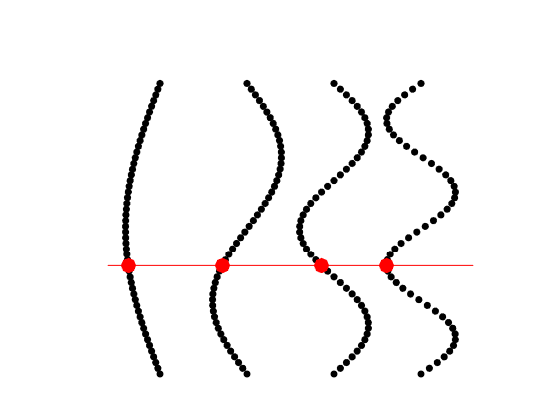

In [3]:
plot(V50(:,1), 0:N+1, 'k.', 'markersize', 20), 
hold on, plot(V50(20,1), 19, 'r.', 'markersize', 25)
plot(V50(:,2)+0.5, 0:N+1, 'k.', 'markersize', 20), 
plot(V50(20,2)+0.5, 19, 'r.', 'markersize', 25)
plot(V50(:,3)+1, 0:N+1, 'k.', 'markersize', 20), 
plot(V50(20,3)+1, 19, 'r.', 'markersize', 25)
plot(V50(:,4)+1.5, 0:N+1, 'k.', 'markersize', 20), 
plot(V50(20,4)+1.5, 19, 'r.', 'markersize', 25)
plot([-0.3, 1.8], [19, 19], 'r')
axis off

Then, calculate the frequencies of oscillation by taking the square root of the eigenvalues:

In [4]:
ev50 = sqrt(diag(E50));

You also want to define a value for $\omega$, then choose a vector of amplitudes and phases... There are many possibilities here, from random values to linear or parabolic distributions...

In [5]:
omega = 2*pi*440;
A = rand(50,1);
% A = (50:-1:1)'/50;
% A = (((1:50)-25).^2/25^2)';
phi = zeros(50,1);

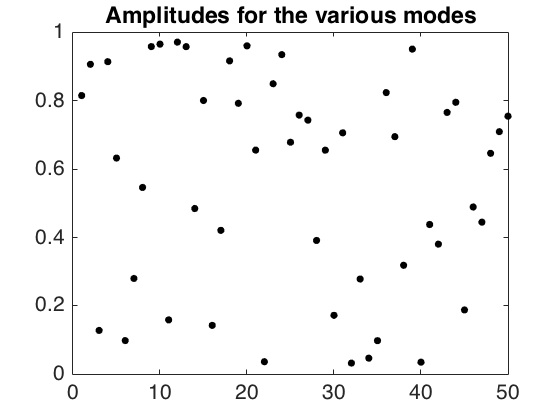

In [6]:
plot(A, '.k', 'markersize', 20)
title('Amplitudes for the various modes')

Choose the mass you want to calculate the displacement of.

In [7]:
pt = 23;

Finally, calculate the oscillation of each mode at that particular point. First, we need to compute the argument of the sine function. For this, we need to create the time variable, from 0 to `DT`, and with a sampling rate of 44.1 kHz. Once we obtain `T`, we can compute the various signals by multiplying the time domain oscillation by the scaling constant, which in turn depends on both the amplitude chosen and the eigenmode displacement at the particular point. 

In [8]:
DT = 2;          % sound duration (in s)
t = (0:DT*44100)/44100;
T = kron(omega*ev50, t) + kron(phi, ones(numel(t),1)');

Amps = V50(pt, :)'.*A;
snd = spdiags(Amps, 0, 50, 50) * sin(T); 

Here's a plot of the initial portion of the first four modes:

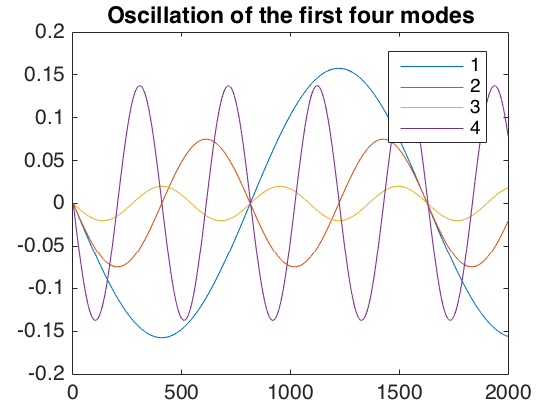

In [9]:
plot(snd(1,1:2000))
hold on, plot(snd(2,1:2000))
plot(snd(3,1:2000)), plot(snd(4,1:2000))
legend('1','2','3','4')
title('Oscillation of the first four modes')
hold off

By summing all the modes, it is now possible to obtain the sound we wanted...

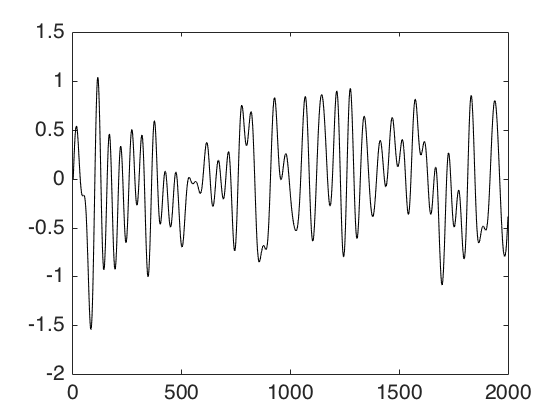

In [10]:
y = sum(snd,1);
plot(y(1:2000), 'k')

... and play it!

In [11]:
soundsc(y, 44100)
audiowrite('modal.wav', y/max(abs(y)), 44100);

You can listen to the generated sound [here](http://blog.albertotorin.it/files/mdof-sound-synthesis/modal.wav).

Also, you can play around with a slightly more elaborate version of this algorithm that you can find [here](https://github.com/atorin/Dynamics3-Lecture/blob/master/MDoF_Modal.m). In this case, the masses and stiffness coefficients for the system are chosen randomly, such that every run of the code gives a different sound.

## Finite difference approach

I have discussed the basics of finite difference codes in a [previous post](http://blog.albertotorin.it/blog/anatomy-fd-sho/). The main ideas, in very loose terms, are:


- __Discretise time__: take the continuous function $u(t)$ and convert it into a discrete function $u(nk) = u^n$, with $n$ integer and $k$ the time step.

- __Discretise differential operators__: differential equations become recursions. Knowing $u^n$, you can calculate $u^{n+1}$.

In the case of the mass-spring system array, the discrete update equation becomes:

$$ M \frac{\vec{u}^{ n+1} - 2\vec{u}^{ n} + \vec{u}^{ n-1}}{k^2} = - K \vec{u}^n. $$ 

I have uploaded [here](https://github.com/atorin/Dynamics3-Lecture/blob/master/MDoF_FD.m) a simple finite difference code with the same spirit of the modal case: masses and stiffness coefficients are chosen randomly, as well as the intial conditions. 

An interesting thing to notice is that for the modal case, one has to choose $N$ amplitudes and $N$ phases. The same number of parameters is required by the finite difference scheme when one specifies the initial conditions $u^0$ and $u^1$. This is obviously not a coincidence, and has to do with the second order nature of the equations of motion. A second order problem requires two initial conditions for each degree of freedom, so a total of $2N$ parameters. 